In [27]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


23:04:58 - cmdstanpy - INFO - Chain [1] start processing
23:04:58 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error on 2024 Test Data: 0.27986074640256087


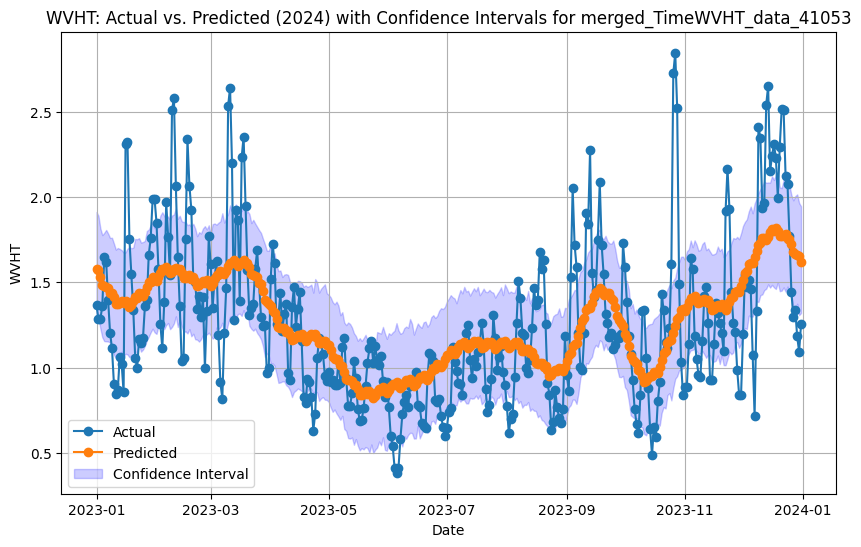

All forecasts saved to forecast.csv


In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os

# List of CSV files, one per station
station_files = [
    'merged_TimeWVHT_data_41053.csv'
    # Add more station files as needed
]

output_file = 'forecast.csv'
first_run = True  # To handle header writing in the output CSV

for file_path in station_files:
    # Extract station_id from filename (adjust logic as needed)
    # Example: station_id from filename "merged_TimeWVHT_data_station1.csv" -> "station1"
    station_id = os.path.splitext(os.path.basename(file_path))[0]
    
    # Load and preprocess data
    df = pd.read_csv(file_path)
    df['Year'] = df['#YY'].astype(int)
    df['Month'] = df['MM'].astype(int)
    df['Day'] = df['DD'].astype(int)
    df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

    # Rename columns for Prophet
    df_prophet = df.rename(columns={'datetime': 'ds', 'WVHT': 'y'})
    
    # Train/test split
    train_df = df_prophet[df_prophet['ds'] < '2024-01-01']
    test_df = df_prophet[df_prophet['ds'] >= '2023-01-01']
    
    if train_df.empty or test_df.empty:
        print(f"Skipping {station_id}: Insufficient data for training or testing.")
        continue
    
    # Train the Prophet model on the training set only
    model = Prophet(yearly_seasonality=True, interval_width=0.60)
    model.fit(train_df)
    
    # Determine how long to forecast into the future
    last_train_date = train_df['ds'].max()
    last_test_date = test_df['ds'].max()
    periods = (last_test_date - last_train_date).days

    
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Extract only forecasts for the test period
    forecast_test = forecast[forecast['ds'] >= '2023-01-01'].copy()
    
    # Merge actual and predicted to compute MAE
    test_merged = pd.merge(test_df[['ds','y']], 
                           forecast_test[['ds','yhat', 'yhat_lower', 'yhat_upper']], 
                           on='ds', how='inner')
    
    # Compute accuracy (MAE)
    mae = mean_absolute_error(test_merged['y'], test_merged['yhat'])
    print("Mean Absolute Error on 2024 Test Data:", mae)
    
    # Convert ds to only month-day format
    forecast_test['ds'] = forecast_test['ds'].dt.strftime('%m-%d')

    # Add station_id column to forecast_test
    forecast_test['station_id'] = station_id
    
    # Select only the required columns
    output_df = forecast_test[['station_id', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    
    # Save to CSV, append if not the first station
    if first_run:
        output_df.to_csv(output_file, index=False)
        first_run = False
    else:
        output_df.to_csv(output_file, index=False, mode='a', header=False)

    
    # Plot actual vs predicted with confidence intervals for this station
    plt.figure(figsize=(10, 6))
    plt.plot(test_merged['ds'], test_merged['y'], label='Actual', marker='o')
    plt.plot(test_merged['ds'], test_merged['yhat'], label='Predicted', marker='o')

    # Add confidence interval as a shaded region
    plt.fill_between(test_merged['ds'], 
                     test_merged['yhat_lower'], 
                     test_merged['yhat_upper'], 
                     color='blue', alpha=0.2, label='Confidence Interval')

    plt.title(f'WVHT: Actual vs. Predicted (2024) with Confidence Intervals for {station_id}')
    plt.xlabel('Date')
    plt.ylabel('WVHT')
    plt.grid(True)
    plt.legend()
    plt.show()

print("All forecasts saved to", output_file)